Część 1

Wykonaj wykresy pudełkowe (ang.box plot), które pozwolą na graficzną identyfikację wartości odstających poprzez przedstawienie kwartyli i wartości skrajnych w danych dotyczących:

In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from google.cloud import bigquery
import db_dtypes
import scipy.stats as stats
import seaborn as sns


In [13]:
os.environ[
    "GOOGLE_APPLICATION_CREDENTIALS"] = "the-webbing-454111-s0-9a04cc92eadc.json"  # lokalizacja pobranego klucza z punktu 1.4.
client = bigquery.Client()

In [14]:
query = """
SELECT DISTINCT
    country_name,
    iso_3166_1_alpha_3 AS `3 letter country code`,
    AVG(new_deceased) AS `new_deceased`,
    AVG(new_confirmed) AS `new_confirmed`,
    AVG(new_persons_vaccinated) AS `new_persons_vaccinated`,
    MAX(population) AS `population`, 
    MAX(gdp_usd) AS `GDP`, 
    MAX(health_expenditure_usd) AS `health_expenditure_usd`,
    AVG(population_density) AS `population density`, 
    CASE 
        WHEN SUM(new_confirmed) = 0 THEN 0 
        ELSE (SUM(new_deceased) * 100) / SUM(new_confirmed) 
    END AS `Deceased to Confirmed cases %`, 
    date,
FROM 
    `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE 
    aggregation_level = 0
GROUP BY 
    country_name, iso_3166_1_alpha_3, date
ORDER BY 
    country_name
"""
query_disease = client.query(query)
query_disease_result = query_disease.result()
disease_df = query_disease_result.to_dataframe()
disease_df.dropna(inplace=True)
disease_df.to_csv('results\\prepared_for_2_ex.csv', index=False)

merged_data_df = pd.read_csv('results\\prepared_for_2_ex.csv')

1.1. liczby nowych zachorowań
1.2. liczby nowych śmierci
1.3. liczby nowych szczepień

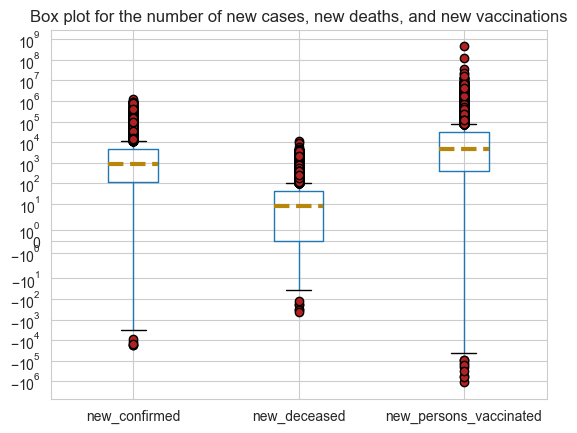

In [15]:
merged_data_df.boxplot(
    ["new_confirmed", "new_deceased", "new_persons_vaccinated"],
    flierprops={'marker': 'o', 'markersize': 6,
                'markerfacecolor': 'firebrick'},
    medianprops={'linestyle': '--', 'linewidth': 3, 'color': 'darkgoldenrod'})
plt.yscale('symlog')
plt.title(
    'Box plot for the number of new cases, new deaths, and new vaccinations')
plt.show()

1.4 Populacji

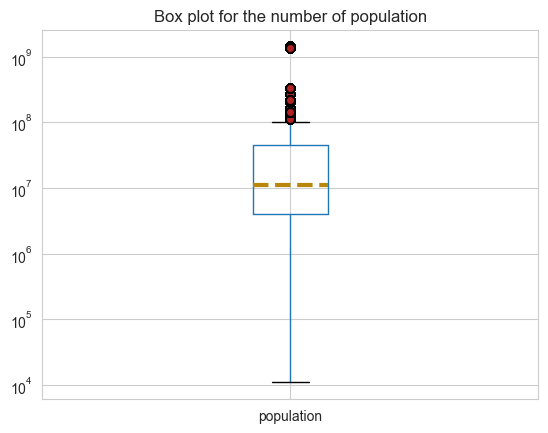

In [16]:
merged_data_df = pd.read_csv('results\\prepared_for_2_ex.csv')

merged_data_df.boxplot(["population"],
                       flierprops={'marker': 'o', 'markersize': 6,
                                   'markerfacecolor': 'firebrick'},
                       medianprops={'linestyle': '--', 'linewidth': 3,
                                    'color': 'darkgoldenrod'})
plt.yscale('symlog')
plt.title('Box plot for the number of population')
plt.show()

1.5 PKB

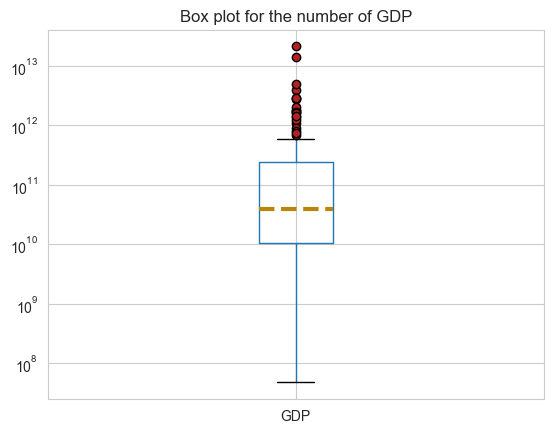

In [17]:
merged_data_df = pd.read_csv('results\\prepared_for_2_ex.csv')
merged_data_df = merged_data_df.drop_duplicates(subset="country_name")
merged_data_df.boxplot(["GDP"], flierprops={'marker': 'o', 'markersize': 6,
                                            'markerfacecolor': 'firebrick'},
                       medianprops={'linestyle': '--', 'linewidth': 3,
                                    'color': 'darkgoldenrod'})
plt.yscale('symlog')
plt.title('Box plot for the number of GDP')
plt.show()

1.6 -> 4 innych różnych informacji, które uznasz za istotne.

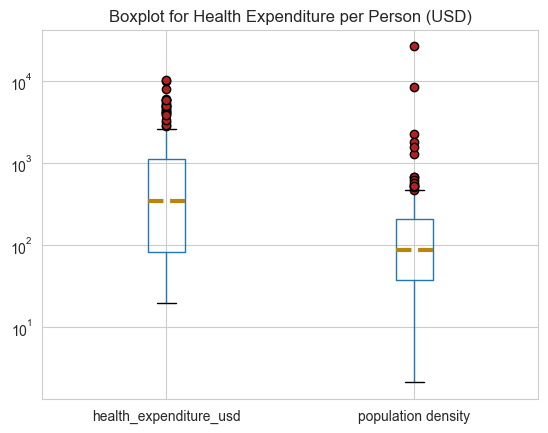

In [18]:
merged_data_df.boxplot(["health_expenditure_usd", "population density"],
                       flierprops={'marker': 'o', 'markersize': 6,
                                   'markerfacecolor': 'firebrick'},
                       medianprops={'linestyle': '--', 'linewidth': 3,
                                    'color': 'darkgoldenrod'})
plt.yscale('symlog')
plt.title('Boxplot for Health Expenditure per Person (USD)')
plt.show()

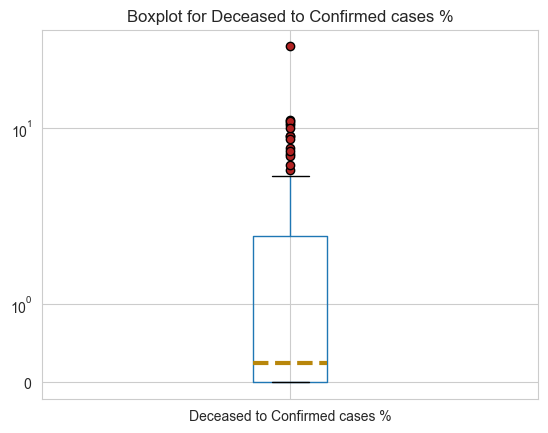

In [19]:
merged_data_df.boxplot(["Deceased to Confirmed cases %"],
                       flierprops={'marker': 'o', 'markersize': 6,
                                   'markerfacecolor': 'firebrick'},
                       medianprops={'linestyle': '--', 'linewidth': 3,
                                    'color': 'darkgoldenrod'})

plt.yscale('symlog')
plt.title('Boxplot for Deceased to Confirmed cases %')
plt.show()

Część 2
Outliery

Metoda Z-Score
Metoda statystyczna, która mierzy, jak wiele odchyleń standardowych wartość jest oddalona od średniej. Wartości z wysokim Z-Score (np. powyżej 2 lub 3) mogą być uznane za wartości odstające, a następnie usunięte. 



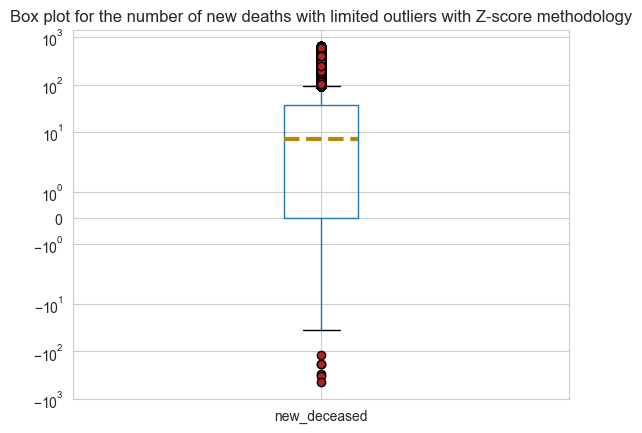

In [20]:
merged_data_df = pd.read_csv('results\\prepared_for_2_ex.csv')

data_for_2_1_1 = merged_data_df[['new_deceased']]

zscores_2_1_1 = stats.zscore(data_for_2_1_1)
zscores_2_1_1 = np.abs(zscores_2_1_1)
data_for_2_1_1_without_outliers = data_for_2_1_1[
    (zscores_2_1_1 <= 2).all(axis=1)]

data_for_2_1_1_without_outliers.boxplot(["new_deceased"],
                                        flierprops={'marker': 'o',
                                                    'markersize': 6,
                                                    'markerfacecolor': 'firebrick'},
                                        medianprops={'linestyle': '--',
                                                     'linewidth': 3,
                                                     'color': 'darkgoldenrod'})
plt.yscale('symlog')
plt.title(
    'Box plot for the number of new deaths with limited outliers with Z-score methodology')
plt.show()

C:\Users\Maciek\AppData\Local\Temp\ipykernel_18208\696477398.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  '3 letter country code', group_keys=False).apply(remove_outliers_in_groups)


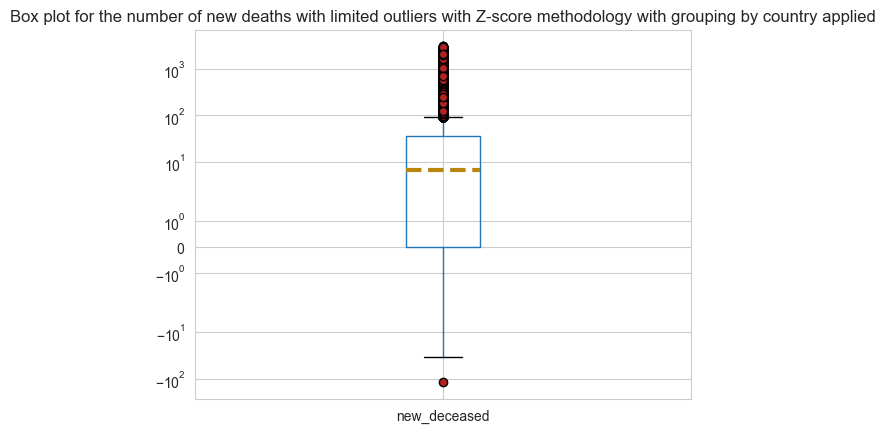

In [21]:
merged_data_df = pd.read_csv('results\\prepared_for_2_ex.csv')

data_for_2_1_2 = merged_data_df[['new_deceased', '3 letter country code']]


def remove_outliers_in_groups(group, threshold=2):
    zscores = np.abs(stats.zscore(group['new_deceased'], nan_policy='omit'))
    return group[zscores <= threshold]


data_for_2_1_2_without_outliers = data_for_2_1_2.groupby(
    '3 letter country code', group_keys=False).apply(remove_outliers_in_groups)

data_for_2_1_2_without_outliers.boxplot(["new_deceased"],
                                        flierprops={'marker': 'o',
                                                    'markersize': 6,
                                                    'markerfacecolor': 'firebrick'},
                                        medianprops={'linestyle': '--',
                                                     'linewidth': 3,
                                                     'color': 'darkgoldenrod'})
plt.yscale('symlog')
plt.title(
    'Box plot for the number of new deaths with limited outliers with Z-score methodology with grouping by country applied')
plt.show()




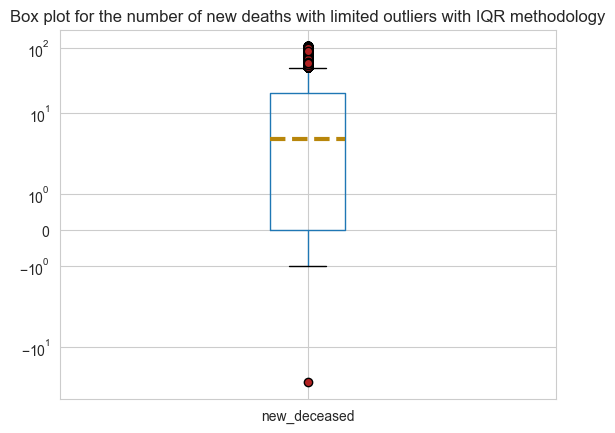

In [22]:
data_for_2_2_1 = merged_data_df[['new_deceased']]
IQR = stats.iqr(data_for_2_2_1)

Q1 = np.percentile(data_for_2_2_1['new_deceased'], 25)
Q3 = np.percentile(data_for_2_2_1['new_deceased'], 75)

data_for_2_2_1_without_outliers = data_for_2_2_1[
    (data_for_2_2_1['new_deceased'] >= Q1 - 1.5 * IQR) &
    (data_for_2_2_1['new_deceased'] <= Q3 + 1.5 * IQR)
    ]

data_for_2_2_1_without_outliers.boxplot(["new_deceased"],
                                        flierprops={'marker': 'o',
                                                    'markersize': 6,
                                                    'markerfacecolor': 'firebrick'},
                                        medianprops={'linestyle': '--',
                                                     'linewidth': 3,
                                                     'color': 'darkgoldenrod'})
plt.yscale('symlog')
plt.title(
    'Box plot for the number of new deaths with limited outliers with IQR methodology')
plt.show()

C:\Users\Maciek\AppData\Local\Temp\ipykernel_18208\1655170209.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_for_2_2_without_outliers = data_for_2_2.groupby('3 letter country code', group_keys=False).apply(remove_iqr_outliers)


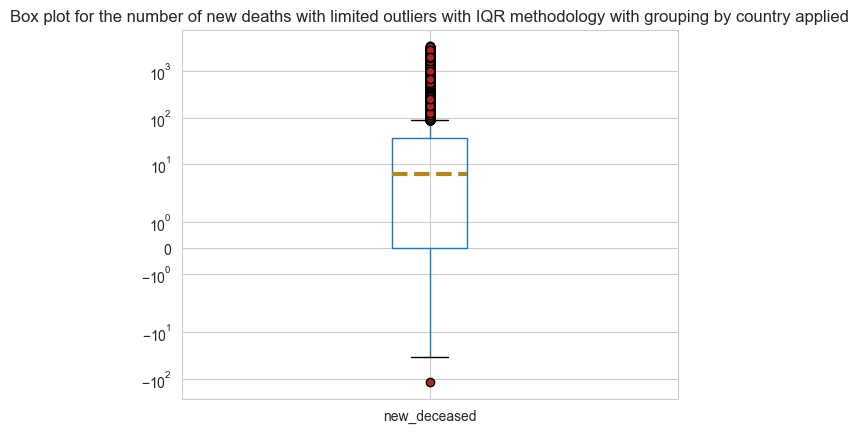

In [23]:
data_for_2_2 = merged_data_df[['new_deceased', '3 letter country code']]


def remove_iqr_outliers(group):
    Q1 = group['new_deceased'].quantile(0.25)
    Q3 = group['new_deceased'].quantile(0.75)
    IQR = Q3 - Q1
    return group[(group['new_deceased'] >= Q1 - 1.5 * IQR) & (
                group['new_deceased'] <= Q3 + 1.5 * IQR)]


data_for_2_2_without_outliers = data_for_2_2.groupby('3 letter country code',
                                                     group_keys=False).apply(
    remove_iqr_outliers)

data_for_2_2_without_outliers.boxplot(["new_deceased"],
                                      flierprops={'marker': 'o',
                                                  'markersize': 6,
                                                  'markerfacecolor': 'firebrick'},
                                      medianprops={'linestyle': '--',
                                                   'linewidth': 3,
                                                   'color': 'darkgoldenrod'})
plt.yscale('symlog')
plt.title(
    'Box plot for the number of new deaths with limited outliers with IQR methodology with grouping by country applied')
plt.show()

Część 3

Obliczenia statystyczne (m.in. średnia, mediana, moda, odchylenie standardowe) pozwolają na zrozumienie rozkładu danych oraz na identyfikację ewentualnych anomalii lub nietypowych wartości. 
Wykonaj następujące obliczenia:


3.1. średnia liczba nowych zachorowań, śmierci i szczepień dla co najmniej 10 wybranych krajów w wybranym miesiącu,

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

countries = ['Malta', 'Czech Republic', 'Ireland', 'Czech Republic', 'Poland',
             'France', 'Norway', 'Germany', 'Denmark', 'Belgium']

merged_covid_df = pd.read_csv('results\\prepared_for_2_ex.csv')
merged_covid_df['date'] = pd.to_datetime(merged_covid_df['date'])
df_filtered = merged_covid_df[(merged_covid_df['date'].dt.year == 2021) & (
            merged_covid_df['date'].dt.month == 10) & (
                                  merged_covid_df['country_name'].isin(
                                      countries))]


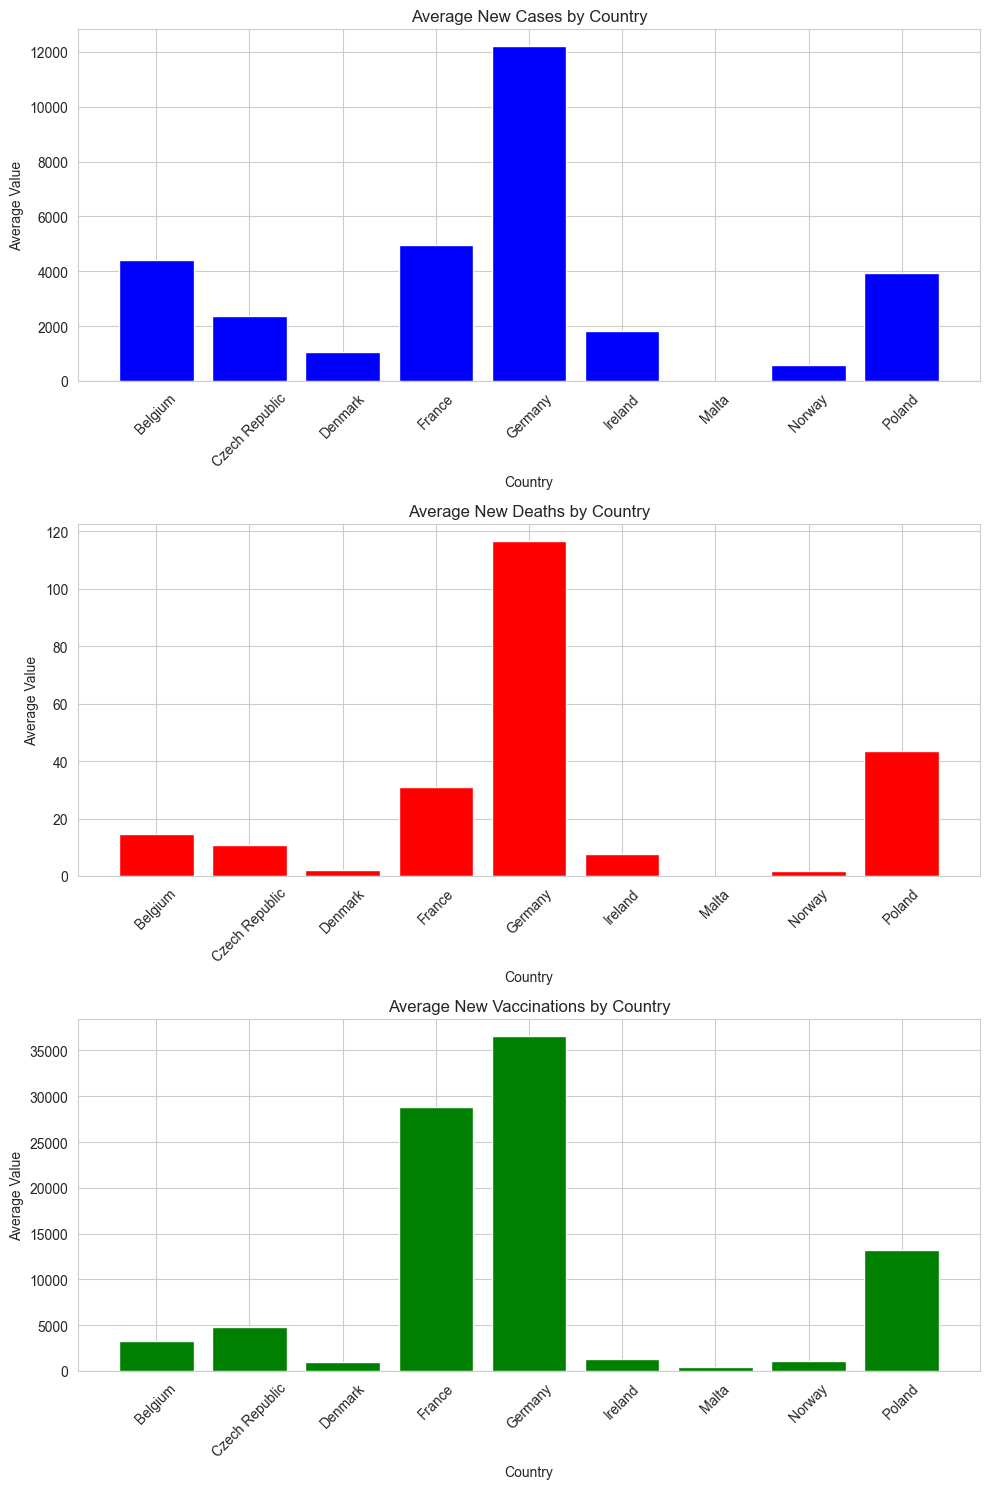

In [25]:
avg_values = df_filtered.groupby(['country_name']).agg(
    {'new_confirmed': 'mean', 'new_deceased': 'mean',
     'new_persons_vaccinated': 'mean'})
avg_values.reset_index(inplace=True)

index = np.arange(len(avg_values['country_name']))

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

ax[0].bar(index, avg_values['new_confirmed'], color='blue', label='New cases')
ax[0].set_title('Average New Cases by Country')
ax[0].set_xlabel('Country')
ax[0].set_ylabel('Average Value')
ax[0].set_xticks(index)
ax[0].set_xticklabels(avg_values['country_name'], rotation=45)

ax[1].bar(index, avg_values['new_deceased'], color='red', label='New deaths')
ax[1].set_title('Average New Deaths by Country')
ax[1].set_xlabel('Country')
ax[1].set_ylabel('Average Value')
ax[1].set_xticks(index)
ax[1].set_xticklabels(avg_values['country_name'], rotation=45)

ax[2].bar(index, avg_values['new_persons_vaccinated'], color='green',
          label='New vaccinations')
ax[2].set_title('Average New Vaccinations by Country')
ax[2].set_xlabel('Country')
ax[2].set_ylabel('Average Value')
ax[2].set_xticks(index)
ax[2].set_xticklabels(avg_values['country_name'], rotation=45)

plt.tight_layout()
plt.show()


3.2. średnia zmiana liczby zachorowań, śmierci i szczepień dla co najmniej 10 wybranych krajów w wybranym miesiącu

In [26]:
import numpy as np

countries = ['Poland', 'Czech Republic', 'Germany', 'France', 'United Kingdom',
             'Japan', 'Canada', 'Italy', 'Belgium', 'Denmark']

merged_covid_df = pd.read_csv('results\\prepared_for_2_ex.csv')
merged_covid_df['date'] = pd.to_datetime(merged_covid_df['date'])
df_filtered = merged_covid_df[(merged_covid_df['date'].dt.year == 2021) & (
        merged_covid_df['date'].dt.month == 10) & (
                                  merged_covid_df['country_name'].isin(
                                      countries))]

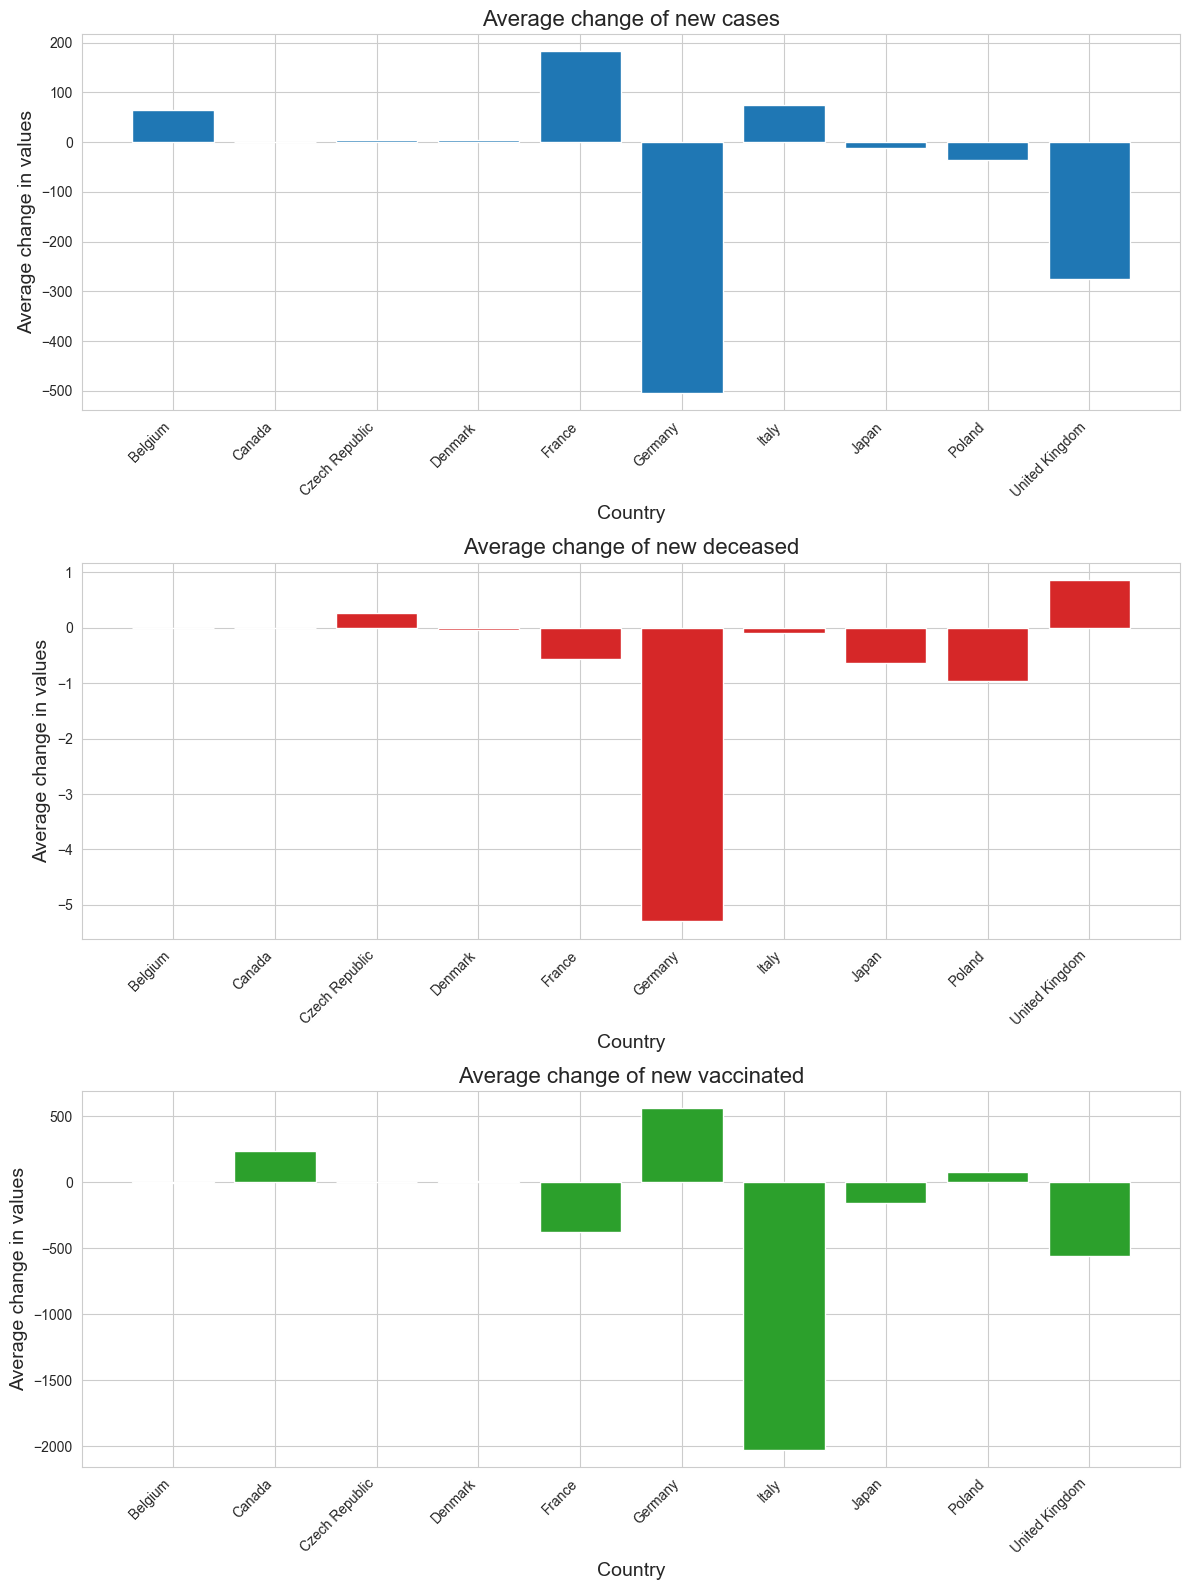

In [27]:
import matplotlib.pyplot as plt
import numpy as np

avg_diff_values = df_filtered.groupby('country_name')[
    ['new_confirmed', 'new_deceased', 'new_persons_vaccinated']].diff()
avg_diff_values = avg_diff_values.groupby(df_filtered['country_name']).mean()
avg_diff_values.reset_index(inplace=True)

index = np.arange(len(avg_diff_values['country_name']))

fig, ax = plt.subplots(3, 1, figsize=(12, 16))

ax[0].bar(index, avg_diff_values['new_confirmed'], color='#1f77b4')
ax[0].set_title('Average change of new cases', fontsize=16)
ax[0].set_xlabel('Country', fontsize=14)
ax[0].set_ylabel('Average change in values', fontsize=14)
ax[0].set_xticks(index)
ax[0].set_xticklabels(avg_diff_values['country_name'], rotation=45, ha='right')

ax[1].bar(index, avg_diff_values['new_deceased'], color='#d62728')
ax[1].set_title('Average change of new deceased', fontsize=16)
ax[1].set_xlabel('Country', fontsize=14)
ax[1].set_ylabel('Average change in values', fontsize=14)
ax[1].set_xticks(index)
ax[1].set_xticklabels(avg_diff_values['country_name'], rotation=45, ha='right')

ax[2].bar(index, avg_diff_values['new_persons_vaccinated'], color='#2ca02c')
ax[2].set_title('Average change of new vaccinated', fontsize=16)
ax[2].set_xlabel('Country', fontsize=14)
ax[2].set_ylabel('Average change in values', fontsize=14)
ax[2].set_xticks(index)
ax[2].set_xticklabels(avg_diff_values['country_name'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

 3.3. mediana liczby nowych zachorowań, śmierci i szczepień dla co najmniej 10 wybranych krajów w wybranym miesiącu, 

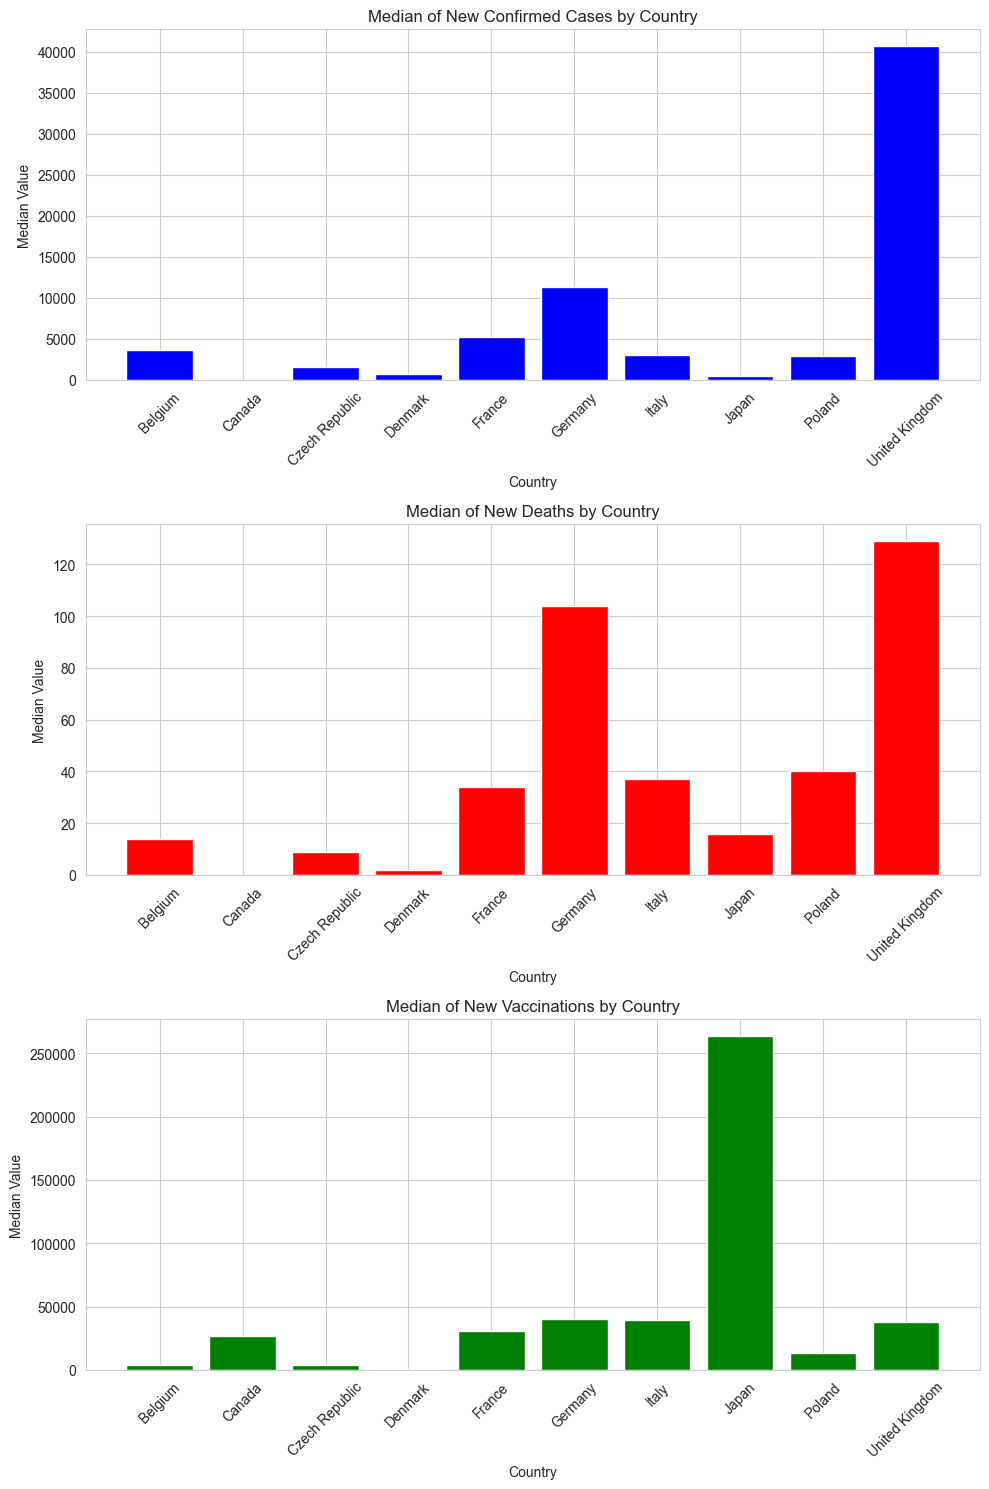

In [28]:
median_values = df_filtered.groupby(['country_name']).agg(
    {'new_confirmed': 'median', 'new_deceased': 'median',
     'new_persons_vaccinated': 'median'})
median_values.reset_index(inplace=True)

index = np.arange(len(median_values['country_name']))

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

ax[0].bar(index, median_values['new_confirmed'], color='blue')
ax[0].set_title('Median of New Confirmed Cases by Country')
ax[0].set_xlabel('Country')
ax[0].set_ylabel('Median Value')
ax[0].set_xticks(index)
ax[0].set_xticklabels(median_values['country_name'], rotation=45)

ax[1].bar(index, median_values['new_deceased'], color='red')
ax[1].set_title('Median of New Deaths by Country')
ax[1].set_xlabel('Country')
ax[1].set_ylabel('Median Value')
ax[1].set_xticks(index)
ax[1].set_xticklabels(median_values['country_name'], rotation=45)

ax[2].bar(index, median_values['new_persons_vaccinated'], color='green')
ax[2].set_title('Median of New Vaccinations by Country')
ax[2].set_xlabel('Country')
ax[2].set_ylabel('Median Value')
ax[2].set_xticks(index)
ax[2].set_xticklabels(median_values['country_name'], rotation=45)

plt.tight_layout()
plt.show()

3.4. odchylenie standardowe liczby nowych zachorowań, śmierci i szczepień dla co najmniej 10 wybranych krajów w wybranym miesiącu,


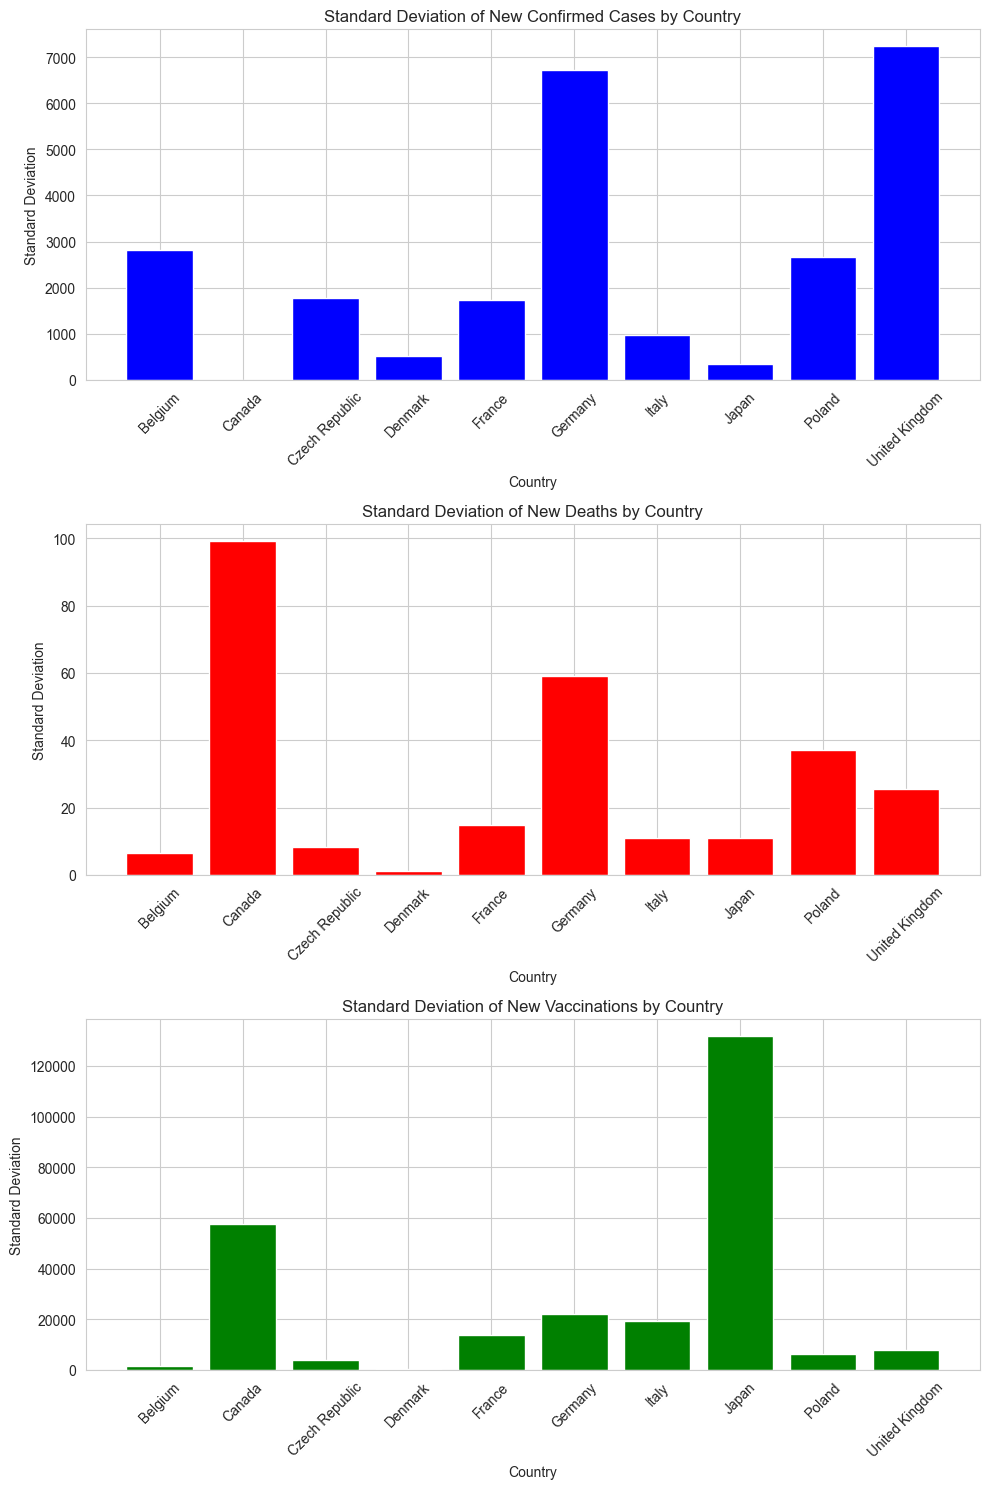

In [29]:
std_values = df_filtered.groupby(['country_name']).agg(
    {'new_confirmed': 'std', 'new_deceased': 'std',
     'new_persons_vaccinated': 'std'})
std_values.reset_index(inplace=True)

index = np.arange(len(std_values['country_name']))

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

ax[0].bar(index, std_values['new_confirmed'], color='blue')
ax[0].set_title('Standard Deviation of New Confirmed Cases by Country')
ax[0].set_xlabel('Country')
ax[0].set_ylabel('Standard Deviation')
ax[0].set_xticks(index)
ax[0].set_xticklabels(std_values['country_name'], rotation=45)

ax[1].bar(index, std_values['new_deceased'], color='red')
ax[1].set_title('Standard Deviation of New Deaths by Country')
ax[1].set_xlabel('Country')
ax[1].set_ylabel('Standard Deviation')
ax[1].set_xticks(index)
ax[1].set_xticklabels(std_values['country_name'], rotation=45)

ax[2].bar(index, std_values['new_persons_vaccinated'], color='green')
ax[2].set_title('Standard Deviation of New Vaccinations by Country')
ax[2].set_xlabel('Country')
ax[2].set_ylabel('Standard Deviation')
ax[2].set_xticks(index)
ax[2].set_xticklabels(std_values['country_name'], rotation=45)

plt.tight_layout()
plt.show()

Przygotowanie danych dla 3.5 oraz 3.6



In [30]:
merged_country_df = pd.read_csv('results\\prepared_for_2_ex.csv')
countries_df = merged_country_df[
    (merged_country_df['country_name'].isin(countries))]

min_values = countries_df.groupby(['country_name']).agg(
    {'new_confirmed': 'min', 'new_deceased': 'min',
     'new_persons_vaccinated': 'min', 'GDP': 'mean', 'population': 'mean'})
min_values.reset_index(inplace=True)

max_values = countries_df.groupby(['country_name']).agg(
    {'new_confirmed': 'max', 'new_deceased': 'max',
     'new_persons_vaccinated': 'max', 'GDP': 'mean', 'population': 'mean'})
max_values.reset_index(inplace=True)

avg_values = countries_df.groupby(['country_name']).agg(
    {'new_confirmed': 'mean', 'new_deceased': 'mean',
     'new_persons_vaccinated': 'mean', 'GDP': 'mean', 'population': 'mean'})
avg_values.reset_index(inplace=True)

index = np.arange(len(min_values['country_name']))

3.5. minimalna, średnia i maksymalna liczba nowych zachorowań, szczepień i śmierci, a PKB co najmniej 10 wybranych krajów,


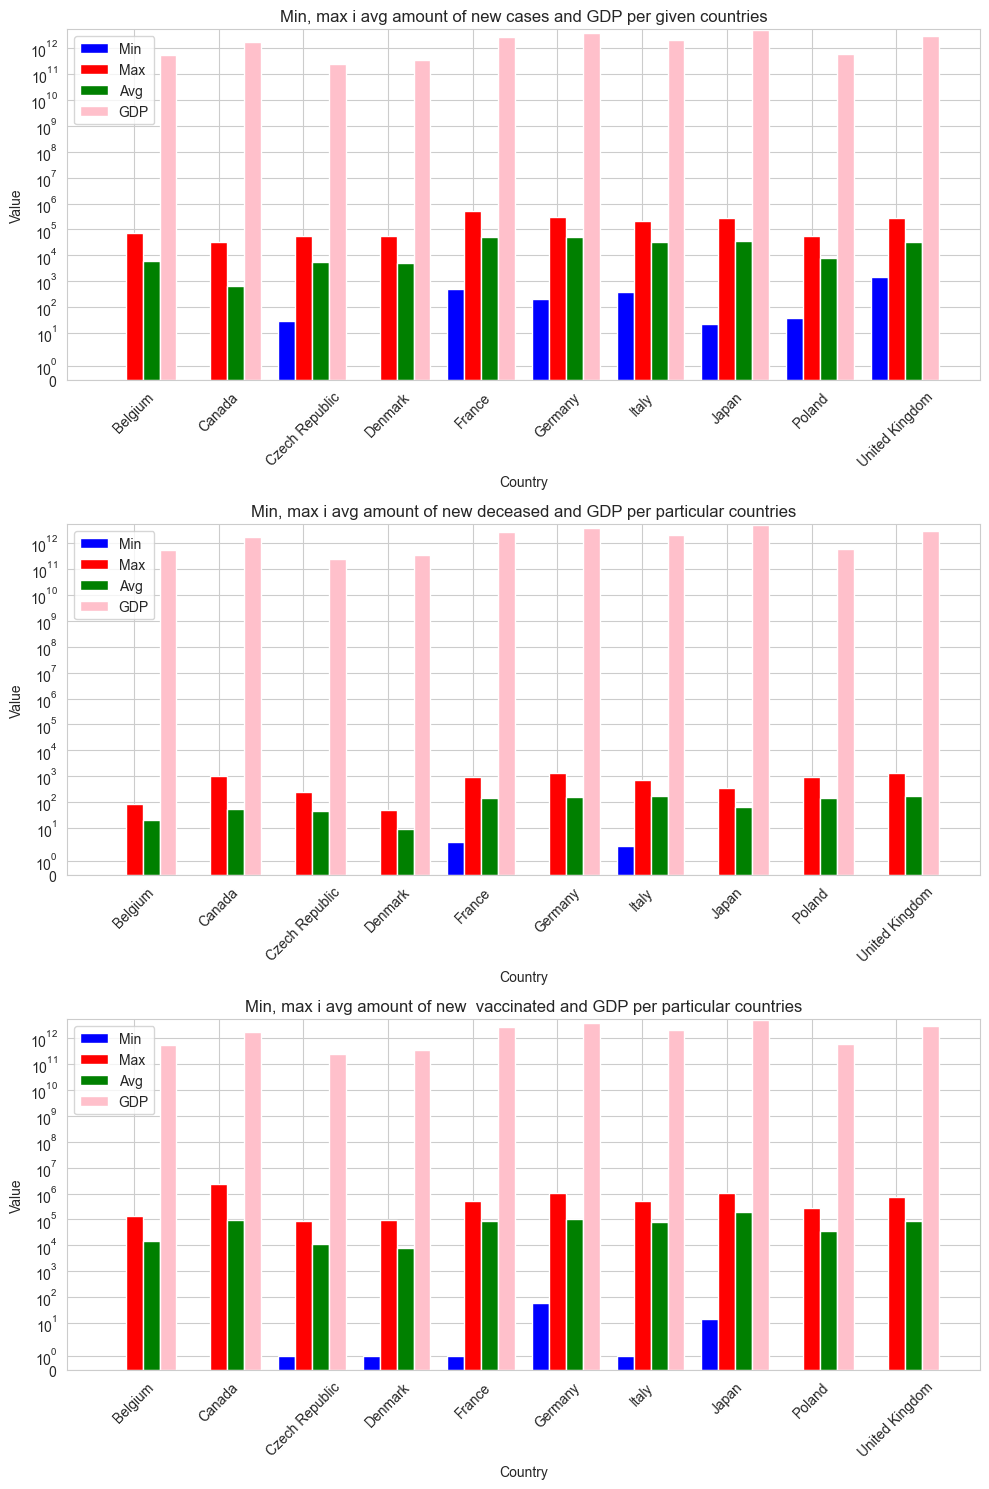

In [31]:
bar_width = 0.2

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
ax[0].bar(index - bar_width, min_values['new_confirmed'], bar_width,
          color='blue', label='Min')
ax[0].bar(index, max_values['new_confirmed'], bar_width, color='red',
          label='Max')
ax[0].bar(index + bar_width, avg_values['new_confirmed'], bar_width,
          color='green', label='Avg')
ax[0].bar(index + 2 * bar_width, avg_values['GDP'], bar_width, color='pink',
          label='GDP')

ax[1].bar(index - bar_width, min_values['new_deceased'], bar_width,
          color='blue', label='Min')
ax[1].bar(index, max_values['new_deceased'], bar_width, color='red',
          label='Max')
ax[1].bar(index + bar_width, avg_values['new_deceased'], bar_width,
          color='green', label='Avg')
ax[1].bar(index + 2 * bar_width, avg_values['GDP'], bar_width, color='pink',
          label='GDP')

ax[2].bar(index - bar_width, min_values['new_persons_vaccinated'], bar_width,
          color='blue', label='Min')
ax[2].bar(index, max_values['new_persons_vaccinated'], bar_width, color='red',
          label='Max')
ax[2].bar(index + bar_width, avg_values['new_persons_vaccinated'], bar_width,
          color='green', label='Avg')
ax[2].bar(index + 2 * bar_width, avg_values['GDP'], bar_width, color='pink',
          label='GDP')

for ax_i in ax:
    ax_i.set_xlabel('Country')
    ax_i.set_ylabel('Value')
    ax_i.set_xticks(index)
    ax_i.set_xticklabels(min_values['country_name'], rotation=45)
    ax_i.legend()
    ax_i.set_yscale('symlog')

ax[0].set_title(
    'Min, max i avg amount of new cases and GDP per given countries')
ax[1].set_title(
    'Min, max i avg amount of new deceased and GDP per particular countries')
ax[2].set_title(
    'Min, max i avg amount of new  vaccinated and GDP per particular countries')

plt.tight_layout()
plt.show()

3.6. minimalna, średnia i maksymalna liczba nowych zachorowań, szczepień i śmierci, a populacja co najmniej 10 wybranych krajów.



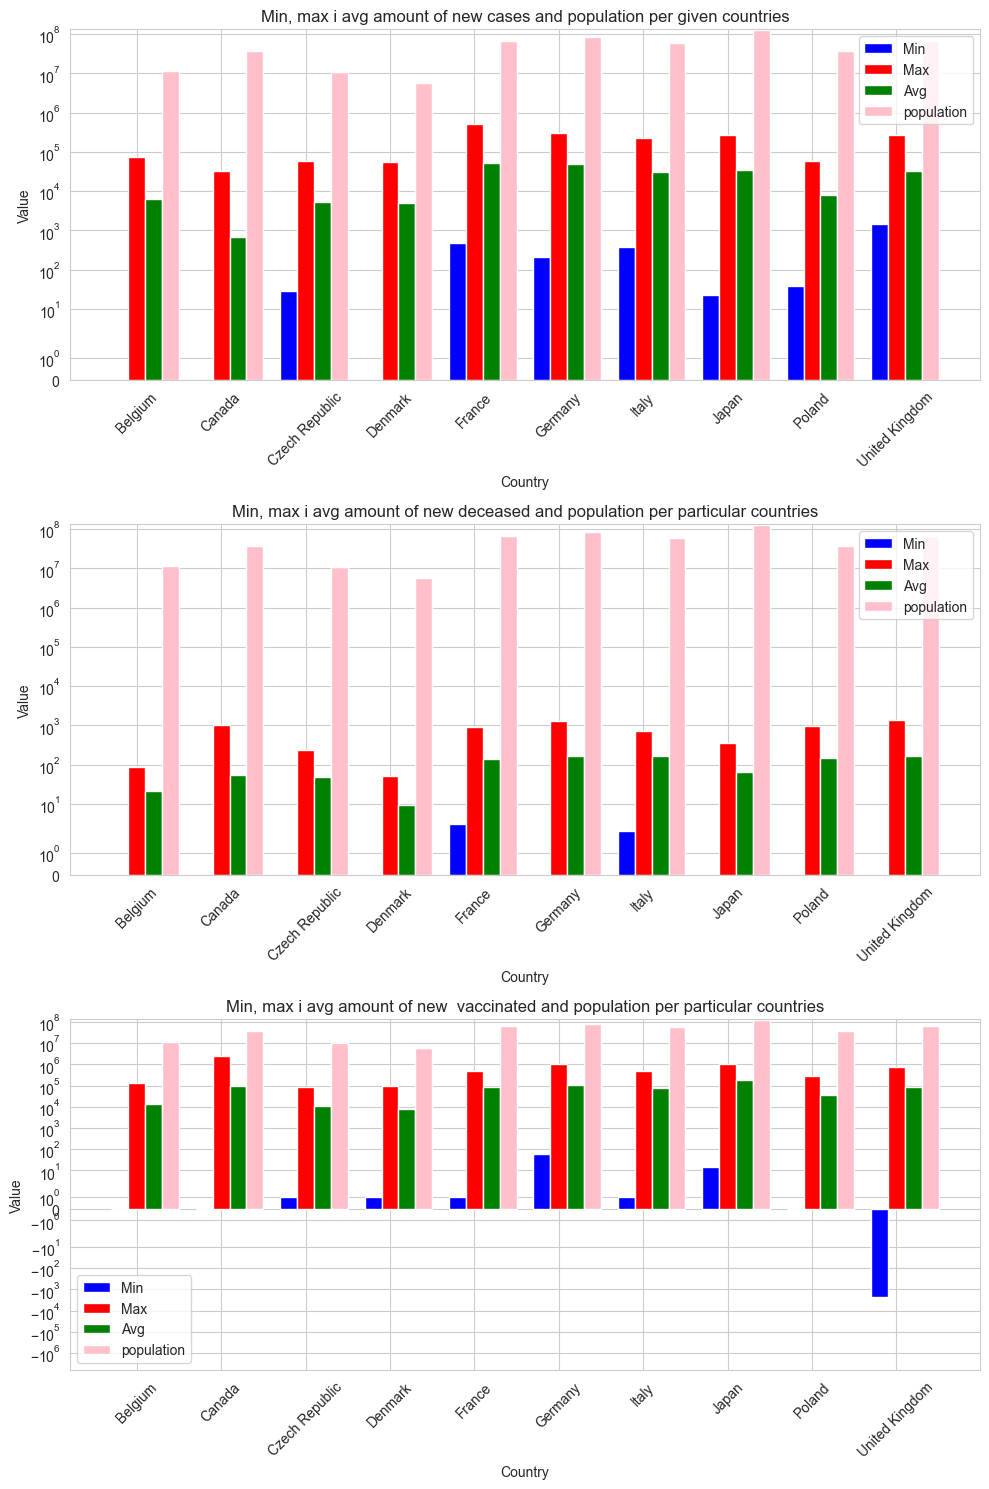

In [32]:
bar_width = 0.2

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
ax[0].bar(index - bar_width, min_values['new_confirmed'], bar_width,
          color='blue', label='Min')
ax[0].bar(index, max_values['new_confirmed'], bar_width, color='red',
          label='Max')
ax[0].bar(index + bar_width, avg_values['new_confirmed'], bar_width,
          color='green', label='Avg')
ax[0].bar(index + 2 * bar_width, avg_values['population'], bar_width,
          color='pink', label='population')

ax[1].bar(index - bar_width, min_values['new_deceased'], bar_width,
          color='blue', label='Min')
ax[1].bar(index, max_values['new_deceased'], bar_width, color='red',
          label='Max')
ax[1].bar(index + bar_width, avg_values['new_deceased'], bar_width,
          color='green', label='Avg')
ax[1].bar(index + 2 * bar_width, avg_values['population'], bar_width,
          color='pink', label='population')

ax[2].bar(index - bar_width, min_values['new_persons_vaccinated'], bar_width,
          color='blue', label='Min')
ax[2].bar(index, max_values['new_persons_vaccinated'], bar_width, color='red',
          label='Max')
ax[2].bar(index + bar_width, avg_values['new_persons_vaccinated'], bar_width,
          color='green', label='Avg')
ax[2].bar(index + 2 * bar_width, avg_values['population'], bar_width,
          color='pink', label='population')

for ax_i in ax:
    ax_i.set_xlabel('Country')
    ax_i.set_ylabel('Value')
    ax_i.set_xticks(index)
    ax_i.set_xticklabels(min_values['country_name'], rotation=45)
    ax_i.legend()
    ax_i.set_yscale('symlog')

ax[0].set_title(
    'Min, max i avg amount of new cases and population per given countries')
ax[1].set_title(
    'Min, max i avg amount of new deceased and population per particular countries')
ax[2].set_title(
    'Min, max i avg amount of new  vaccinated and population per particular countries')

plt.tight_layout()
plt.show()

Część 4

Normalizacja danych polega na przeskalowaniu wartości zmiennych do określonego zakresu, np. [0, 1], co ułatwia porównanie różnych zmiennych między sobą.

Wykonaj normalizację dla następujących przypadków:

4.1. liczba zachorowań na określoną przez Ciebie liczbę osób (np. na 1000 osób),

4.2. liczba szczepień na określoną przez Ciebie liczbę osób (np. na 1000 osób),

4.3. liczba zgonów na określoną przez Ciebie liczbę osób (np. na 1000 osób),

4.4. co najmniej 4 dodatkowe, które uznasz za istotne.

4.1

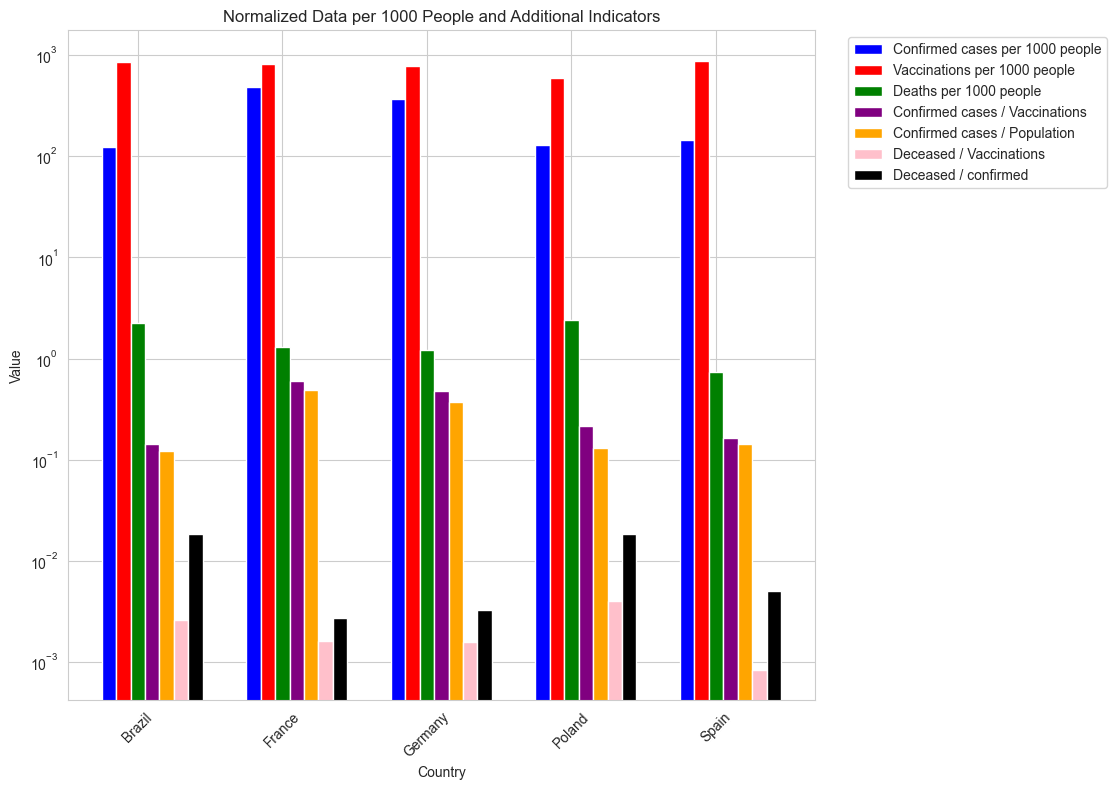

In [33]:
import matplotlib.pyplot as plt
import numpy as np

persons = 1000
countries = ['Poland', 'Germany', 'France', 'Spain', 'Brazil']

# Filtrowanie danych
merged_country_df = merged_country_df.drop_duplicates(subset='country_name')
df_filtered = merged_covid_df[merged_covid_df['country_name'].isin(countries)]

# Grupowanie danych po kraju
sum_values = df_filtered.groupby('country_name').agg({
    'new_confirmed': 'sum',
    'new_deceased': 'sum',
    'new_persons_vaccinated': 'sum'
})
sum_values.reset_index(inplace=True)

# Dodanie populacji do danych
sum_values['population'] = sum_values['country_name'].map(
    merged_country_df.set_index('country_name')['population'])

# Normalizacja: liczba zachorowań na 1000 osób
sum_values['confirmed_per_1000'] = (sum_values['new_confirmed'] / sum_values[
    'population']) * persons

# Normalizacja: liczba szczepień na 1000 osób
sum_values['persons_vaccinated_per_1000'] = (sum_values[
                                                 'new_persons_vaccinated'] /
                                             sum_values[
                                                 'population']) * persons

# Normalizacja: liczba zgonów na 1000 osób
sum_values['deceased_per_1000'] = (sum_values['new_deceased'] / sum_values[
    'population']) * persons

# Dodatkowe normalizacje:
# 1. Stosunek liczby zachorowań do liczby zaszczepionych na 1000 osób
sum_values['confirmed_to_vaccinated_ratio'] = sum_values[
                                                  'confirmed_per_1000'] / \
                                              sum_values[
                                                  'persons_vaccinated_per_1000']

# 2. Liczba zachorowań na osobę w danym kraju
sum_values['confirmed_per_person'] = sum_values['new_confirmed'] / sum_values[
    'population']

# 3. Stosunek zgonów do przypadków zachorowań (deaths per cases)
sum_values['deaths_per_case'] = sum_values['new_deceased'] / sum_values[
    'new_confirmed']

# 4. Stosunek liczby zachorowań do populacji
sum_values['confirmed_to_population_ratio'] = sum_values['new_confirmed'] / \
                                              sum_values['population']

# 5. Stosunek liczby zgonów do szczepień
sum_values['deceased_to_persons_vaccinated'] = sum_values[
                                                   'deceased_per_1000'] / \
                                               sum_values[
                                                   'persons_vaccinated_per_1000']

# 6. Stosunek liczby zgonów do zachorowań
sum_values['deceased_to_confirmed'] = sum_values['deceased_per_1000'] / \
                                      sum_values['confirmed_per_1000']

index = np.arange(len(sum_values['country_name']))
bar_width = 0.1

fig, ax = plt.subplots(figsize=(12, 8))

# Tworzenie różnych słupków dla normalizowanych danych
ax.bar(index - 2 * bar_width, sum_values['confirmed_per_1000'], bar_width,
       color='blue', label='Confirmed cases per 1000 people')
ax.bar(index - bar_width, sum_values['persons_vaccinated_per_1000'], bar_width,
       color='red', label='Vaccinations per 1000 people')
ax.bar(index, sum_values['deceased_per_1000'], bar_width, color='green',
       label='Deaths per 1000 people')

# Dodanie etykiet dla innych normalizacji
ax.bar(index + bar_width, sum_values['confirmed_to_vaccinated_ratio'],
       bar_width, color='purple', label='Confirmed cases / Vaccinations')
ax.bar(index + 2 * bar_width, sum_values['confirmed_to_population_ratio'],
       bar_width, color='orange', label='Confirmed cases / Population')
ax.bar(index + 3 * bar_width, sum_values['deceased_to_persons_vaccinated'],
       bar_width, color='pink', label='Deceased / Vaccinations')
ax.bar(index + 4 * bar_width, sum_values['deceased_to_confirmed'], bar_width,
       color='black', label='Deceased / confirmed')

ax.set_xlabel('Country')
ax.set_ylabel('Value')
ax.set_yscale('log')
ax.set_xticks(index)
ax.set_xticklabels(sum_values['country_name'], rotation=45)
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
ax.set_title('Normalized Data per 1000 People and Additional Indicators')

plt.tight_layout()
plt.show()

Zad 5

In [34]:
query = """
SELECT DISTINCT
    country_name,
    iso_3166_1_alpha_3 AS `3 letter country code`,
    AVG(new_deceased) AS `new_deceased`,
    AVG(new_confirmed) AS `new_confirmed`,
    AVG(new_persons_vaccinated) AS `new_persons_vaccinated`,
    MAX(cumulative_confirmed) AS `total_confirmed`,
    MAX(cumulative_deceased) AS `total_deceased`,
    MAX(cumulative_persons_vaccinated) AS `total_persons_vaccinated`,
    MAX(population) AS `population`, 
    MAX(gdp_usd) AS `GDP`, 
    MAX(gdp_per_capita_usd) AS `GDP_per_capita`,
    MAX(human_capital_index) AS `human_capital_index`,
    MAX(population_rural) AS `rural_population`,
    MAX(human_development_index) AS `human_development_index`,
    MAX(search_trends_cough) AS `search_trends_cough`,
    MAX(life_expectancy) AS `life_expectancy`, 
    MAX(stringency_index) AS `stringency_index`,
    MAX(rainfall_mm) AS `rainfall`,
    MAX(relative_humidity) AS `relative_humidity`,
    AVG(health_expenditure_usd) AS `health_expenditure_usd`,
    AVG(population_density) AS `population density`, 
    CASE 
        WHEN SUM(new_confirmed) = 0 THEN 0 
        ELSE (SUM(new_deceased) * 100) / SUM(new_confirmed) 
    END AS `Deceased to Confirmed cases %`, 
    date,
FROM 
    `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE 
    aggregation_level = 0
GROUP BY 
    country_name, iso_3166_1_alpha_3, date
ORDER BY 
    country_name
"""
query_disease = client.query(query)
query_disease_result = query_disease.result()
disease_df = query_disease_result.to_dataframe()
disease_df.dropna(inplace=True)
disease_df.to_csv('results\\prepared_for_2_5_ex.csv', index=False)

merged_data_df = pd.read_csv('results\\prepared_for_2_5_ex.csv')
data_for_5 = pd.read_csv('results\\prepared_for_2_5_ex.csv')


5.1. liczba nowych zachorowań, szczepień i zgonów, a liczba nowych zachorowań, szczepień i zgonów,


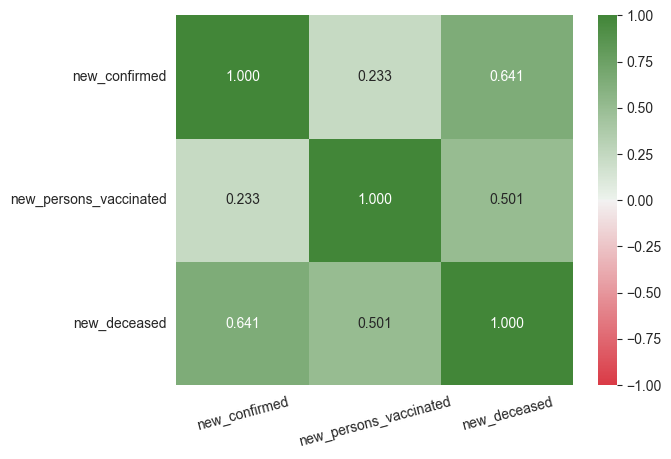

In [49]:
data_for_5_1 = data_for_5[
    ['new_confirmed', 'new_persons_vaccinated', 'new_deceased']]
data_for_5_1_corr = data_for_5_1.corr()
axis_corr = sns.heatmap(
    data_for_5_1_corr,
    cmap=sns.diverging_palette(10, 125, n=5000),
    annot=True,
    fmt=".3f",
    vmax=1,
    vmin=-1,
)
plt.xticks(rotation=15)

plt.show()

5.2. liczba nowych zachorowań, szczepień, zgonów, a łączna liczba zachorowań, szczepień, zgonów,


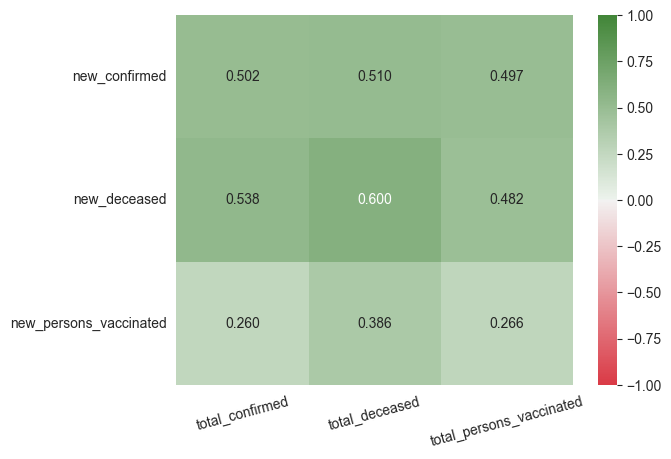

In [52]:
data_for_5_2 = data_for_5[
    ['new_confirmed', 'new_deceased', 'new_persons_vaccinated',
     'total_confirmed', 'total_deceased', 'total_persons_vaccinated']]

data_for_5_2_corr = data_for_5_2.corr()
data_for_5_2_corr = data_for_5_2_corr.iloc[0:3, 3:6]
axis_corr = sns.heatmap(
    data_for_5_2_corr,
    cmap=sns.diverging_palette(10, 125, n=1000),
    annot=True,
    vmin=-1,
    fmt=".3f",
    vmax=1,
)

plt.xticks(rotation=15)
plt.show()

5.3. wskaźniki gospodarcze, a liczba nowych zachorowań, szczepień i zgonów,


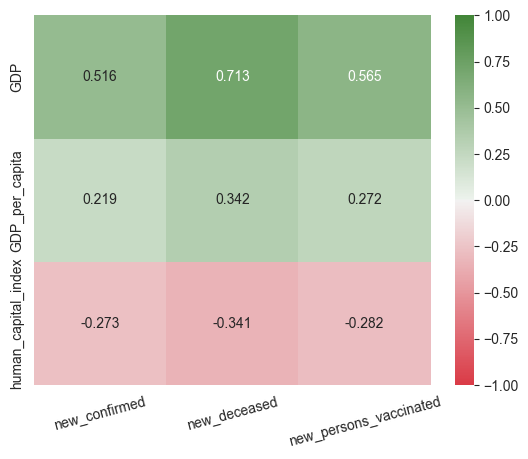

In [51]:
data_for_5_3 = data_for_5[
    ['GDP', 'GDP_per_capita', 'human_capital_index', 'new_confirmed',
     'new_deceased', 'new_persons_vaccinated']]
data_for_5_3_corr = data_for_5_3.corr()
data_for_5_3_corr = data_for_5_3_corr.iloc[0:3, 3:6]
axis_corr = sns.heatmap(
    data_for_5_3_corr,
    cmap=sns.diverging_palette(10, 125, n=1000),
    annot=True,
    vmin=-1,
    fmt=".3f",
    vmax=1,

)

plt.xticks(rotation=15)
plt.show()

5.4. parametry demograficzne, a liczba nowych zachorowań, szczepień i zgonów,



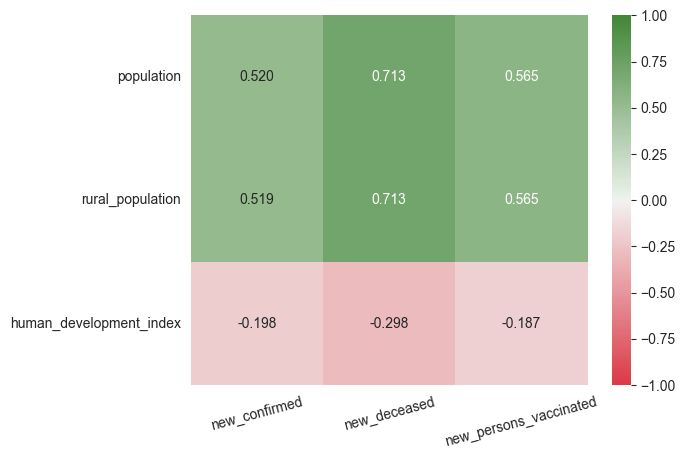

In [50]:
data_for_5_4 = data_for_5[
    ['population', 'rural_population', 'human_development_index',
     'new_confirmed',
     'new_deceased', 'new_persons_vaccinated']]
data_for_5_4_corr = data_for_5_4.corr()
data_for_5_4_corr = data_for_5_4_corr.iloc[0:3, 3:6]
axis_corr = sns.heatmap(
    data_for_5_4_corr,
    cmap=sns.diverging_palette(10, 125, n=1000),
    annot=True,

    fmt=".3f",
    vmax=1,
    vmin=-1,
)

plt.xticks(rotation=15)
plt.show()

5.5. co najmniej 4 dodatkowe korelacje pomiędzy różnymi danymi.



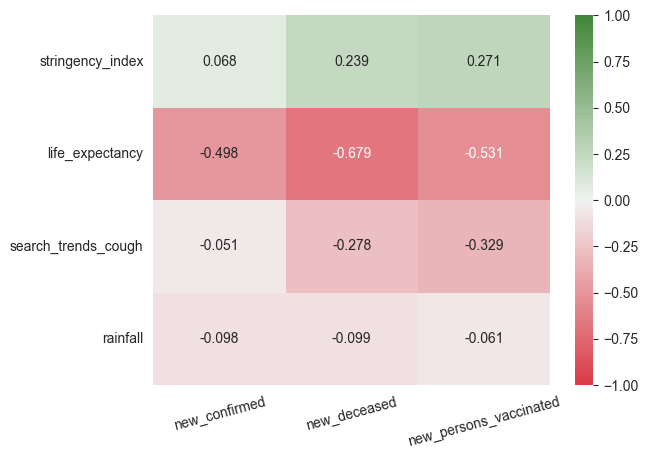

In [42]:
data_for_5_5 = data_for_5[
    ['stringency_index', 'life_expectancy', 'search_trends_cough', 'rainfall',
     'relative_humidity', 'new_confirmed',
     'new_deceased', 'new_persons_vaccinated']]
data_for_5_5_corr = data_for_5_5.corr()
data_for_5_5_corr = data_for_5_5_corr.iloc[0:4, 5:8]
axis_corr = sns.heatmap(
    data_for_5_5_corr,
    cmap=sns.diverging_palette(10, 125, n=1000),
    annot=True,
    fmt=".3f",
    vmax=1,
    vmin=-1,
)

plt.xticks(rotation=15)
plt.show()